# NLP and Reddit Subcommunities - Modeling
---

In this notebook, our objective is to build models that can accurately classify the subreddit from which a given post originates. To achieve this, we will employ pipelines, grid-searching (GridSearchCV) and randomized-searching (RandomizedSearchCV), and iterating through different hyperparameters to evaluate the performance of various machine learning algorithms. Our focus will be on testing classification models such as Logistic Regression, Multinomial Naive Bayes, and Support Vector Machines. Additionally, we will address the challenges of overfitting or underfitting by considering approaches like Random Forest or Gradient Boosting, respectively. We will be taking the following approach:

For more information on the data pulling and initial data cleaning, see the [initial notebook](./code/01_PRAW_Data_Acquisition_Initial_Cleaning.ipynb) of this analysis. For data exploration, further cleaning, and visualization, see the [second notebook](./02_EDA_and_Cleaning) of this analysis.

For more information on the background, a summary of methods, and findings, please see the associated [README](./README.md) for this analysis.

### Contents:
- [I. Baseline and Pre-Processing Functions](#I.-Baseline-and-Pre-Processing-Functions)
- [II. Model-Building and Testing](#II.-Model-Building-and-Testing)
    - [Pipelines and GridSearch / RandomizedSearch](#Pipelines-and-GridSearch-/-RandomizedSearch)
        - [Model 1: Logistic Regression](#Model-1:-Logistic-Regression)
        - [Model 2: Multinomial Naive Bayes](#Model-2:-Multinomial-Naive-Bayes)
        - [Model 3: Support Vector Machine](#Model-3:-Support-Vector-Machine)
    - [Ensembling](#Ensembling)
    - [Reducing Overfitting](#Reducing-Overfitting)
        - [Model 4: Random Forest and ExtraTrees](#Model-4:-Random-Forest-and-ExtraTrees)
- [III. Model Summarization](#II.-Model-Summarization)
- [IV. Final Model](#III.-Final-Model)
---

In [1]:
import warnings
warnings.filterwarnings('ignore') # Notebook was run with warnings enabled and significant ones have been addressed, remaining warnings are insignificant and have been suppressed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.svm import LinearSVC, SVC
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier

In [3]:
snowski = pd.read_csv('../data/Clean/snow_ski2.csv')
snowski.head()

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
0,1.686844e+09,bas1cred,26,0.91,19,snowboardingnoobs,my first board. ready for the upcoming season!!,my first board ready for the upcoming season,my first board readi for the upcom season,48,8
1,1.686786e+09,Pooffios,3,1.00,12,snowboardingnoobs,"outer side foot pain hi all, i was hoping to g...",outer side foot pain hi all i wa hoping to get...,outer side foot pain hi all i wa hope to get s...,301,60
2,1.686781e+09,trips69420,2,0.75,15,snowboardingnoobs,first board? looking to probably grab this as ...,first board looking to probably grab this a my...,first board look to probabl grab thi as my fir...,274,53
3,1.686779e+09,twinbee,11,0.87,0,snowboardingnoobs,i did a front-side 180 today! more than one in...,i did a front side 180 today more than one in ...,i did a front side 180 today more than one in ...,1565,289
4,1.686767e+09,Madden_Stephen,2,0.67,24,snowboardingnoobs,step-on boot recommendation? i’ve done a decen...,step on boot recommendation i ve done a decent...,step on boot recommend i ve done a decent bit ...,686,122


---
## I. Baseline and Pre-Processing Functions
##### Please note: 
- ##### Lemmatizing and Stemming functions were generated and tested, but not all are used as final parameters in any of our models. The models were also run using "lem_text" and "stem_text" as target variables directly, but did not have any impact. 
- ##### A list of custom stop words was created to assist our model in identifying the subreddit from which a post originated (e.g., snowboard, snowboarding, ski, skiing). These custom words were tested as stop words in our models, but were ultimately excluded from further consideration. Introducing this additional complexity to our model is unnecessary and not aligned with our problem statement. The code for incorporating these custom stop words has been commented out below.
---

In [4]:
# Define baseline
snowski.subreddit.value_counts(normalize=True)

skiing               0.51242
snowboardingnoobs    0.48758
Name: subreddit, dtype: float64

##### <span style = 'color:blue'> Our model must have an accuracy score > 51.2% to be useful.</span>

In [5]:
snowski['subreddit'] = snowski['subreddit'].map({'snowboardingnoobs': 1, 'skiing': 0})

In [6]:
# Function for Lemmatizing
def lemmatize_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
        
    # Lemmatize and Rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_txt])

In [7]:
# Function for Stemming
def stem_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate Stemmer
    p_stemmer = PorterStemmer()

    # Stem and Rejoin
    return ' '.join([p_stemmer.stem(word) for word in split_txt])

In [8]:
# Create and save custom stopwords

# english_stopwords = CountVectorizer(stop_words='english').get_stop_words() # source: https://scikit-learn-ts-git-feature-docs-2-saasify.vercel.app/docs/classes/CountVectorizer
# custom_words = ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit']
# custom_words = list(english_stopwords) + custom_words

In [9]:
X = snowski['text']
y = snowski['subreddit']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1527) 

---
## II. Model-Building and Testing
---

### Pipelines and GridSearch / RandomizedSearch

##### Please note that the parameter grids used for optimization contained more parameters than those shown below. To improve computational efficiency, only a selection of optimal parameters are included in the grids below, while others were excluded to minimize rerun time and avoid fitting unnecessary models.

#### Model 1: Logistic Regression

In [11]:
# Create pipeline that tests b/t CVEC and TVEC transformers and an estimator
pipe_log = Pipeline([
                 ('vec', None),
                 ('logr', LogisticRegression(solver = 'liblinear', max_iter=1000))])

In [12]:
# Define hyperparameters
pgrid_logr =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.85], #tested 0.8, 0.95 as well
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,10.0,10),
    'logr__penalty': ['l2'] #tested l1, l2 was more optimal
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.85],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,10.0,10),
    'logr__penalty': ['l2']
    }
]

In [13]:
%%time

# Fit model via GridSearch
gs_log = GridSearchCV(pipe_log, pgrid_logr, cv=5, n_jobs=10)
gs_log.fit(X_train, y_train)

CPU times: total: 4.91 s
Wall time: 2min 30s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('logr',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=10,
             param_grid=[{'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                          'logr__penalty': ['l2'], 'vec': [CountVectorizer()],
                          'vec__max_df': [0.85],
                          'vec__max_features':...
                          'vec__stop_words': [None, 'english']},
                         {'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                          'logr__penalty': ['l2'],
                          'vec': [TfidfVectorizer(max_df=0.85,
                                                  max_features=7000, min_df=2,
                                                  stop_words='english')],
                          'vec__max_df': [0.85],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [2, 3],
                          'vec__stop_words': [None, 'english']}])

In [14]:
# Make predictions for Accuracy Report
preds_log = gs_log.predict(X_test)

In [15]:
b1 = "\033[1m"
b0 = "\033[0m"

print(f'--------- {b1}Logistic Regression w/ GridSearch{b0} ---------') # source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
print(f'------------------- Train: {round(gs_log.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_log.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_log.best_params_)

--------- Logistic Regression w/ GridSearch ---------
------------------- Train: 0.9532 -------------------
------------------- Test: 0.8801 --------------------
Best Params: {'logr__C': 2.2611111111111106, 'logr__penalty': 'l2', 'vec': TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2, stop_words='english'), 'vec__max_df': 0.85, 'vec__max_features': 7000, 'vec__min_df': 2, 'vec__stop_words': 'english'}


In [16]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_log = RandomizedSearchCV(pipe_log, pgrid_logr_best, cv=5, n_iter=10, n_jobs=10)
rs_log.fit(X_train, y_train)

CPU times: total: 484 ms
Wall time: 11.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('logr',
                                              LogisticRegression(max_iter=1000,
                                                                 solver='liblinear'))]),
                   n_jobs=10,
                   param_distributions=[{'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                                         'logr__penalty': ['l2'],
                                         'vec': [CountVectorizer()],
                                         'vec__max_df': [0.85],
                                         'vec_...
                                         'vec__stop_words': [None, 'english']},
                                        {'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                                         'logr__penalty': ['l2'],
                                         'vec': [TfidfVectorizer(max_df=0.85,
                                                                 max_features=8000,
                                                                 min_df=2)],
                                         'vec__max_df': [0.85],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [2, 3],
                                         'vec__stop_words': [None, 'english']}])

In [17]:
preds_log_r = rs_log.predict(X_test)

In [18]:
print(f'------ {b1}Logistic Regression w/ RandomizedSearch{b0} ------')
print(f'------------------- Train: {round(rs_log.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_log.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_log.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

------ Logistic Regression w/ RandomizedSearch ------
------------------- Train: 0.9728 -------------------
------------------- Test: 0.8836 --------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 2, 'vec__max_features': 8000, 'vec__max_df': 0.85, 'vec': TfidfVectorizer(max_df=0.85, max_features=8000, min_df=2), 'logr__penalty': 'l2', 'logr__C': 5.577777777777777}


In [28]:
%%time 
RandomizedSearch gives a slightly different testing score and parameters each run (when done without random_state), I want to see the average and SD over 30 runs to make sure random 
    # parameters chosen from single run are reprsentative
num_runs = 35  # Number of runs
results = []

for i in range(num_runs):
    rs_log = RandomizedSearchCV(pipe_log, pgrid_logr, cv=5, n_iter=10, n_jobs=10)
    rs_log.fit(X_train, y_train)
    results.append(rs_log.score(X_test, y_test))
    
scr = sum(results) / len(results)
scr_sd = (sum((i - scr)**2 for i in results) / len(results))**0.5
lcl = scr - 1.96*scr_sd
ucl = scr + 1.96*scr_sd

print(f'MEAN: {round(scr,4)}')
print(f'SD: {round(scr_sd,4)}')
print(f'95% CI: ({round(lcl,4)}, {round(ucl,4)})')

---
#### Model 2: Multinomial Naive Bayes

In [29]:
pipe_nb = Pipeline([
    ('vec', None),
    ('nb', MultinomialNB())
])

In [30]:
pgrid_nb =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.80, 0.90],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'nb__alpha': [.01, 0.5, 1.0, 5.0]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.80, 0.90],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'nb__alpha': [.01, 0.5, 1.0, 5.0]
    }
]

In [31]:
%%time

gs_nb = GridSearchCV(pipe_nb, pgrid_nb, cv=5, n_jobs=5)
gs_nb.fit(X_train, y_train)

CPU times: total: 5.09 s
Wall time: 1min 52s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None), ('nb', MultinomialNB())]),
             n_jobs=5,
             param_grid=[{'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                          'vec': [CountVectorizer()], 'vec__max_df': [0.8, 0.9],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [2, 3],
                          'vec__stop_words': [None, 'english']},
                         {'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                          'vec': [TfidfVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=3,
                                                  stop_words='english')],
                          'vec__max_df': [0.8, 0.9],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [2, 3],
                          'vec__stop_words': [None, 'english']}])

In [23]:
# Make predictions for Accuracy Report
preds_nb = gs_nb.predict(X_test)

In [24]:
print(f'---------- {b1}Multinomial Bayes w/ GridSearch{b0} ----------')
print(f'------------------- Train: {round(gs_nb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_nb.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_nb.best_params_)

---------- Multinomial Bayes w/ GridSearch ----------
------------------- Train: 0.8905 -------------------
------------------- Test: 0.8566 --------------------
Best Params: {'nb__alpha': 5.0, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3, stop_words='english'), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': 'english'}


In [25]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_nb = RandomizedSearchCV(pipe_nb, pgrid_nb, cv=5, n_iter=10, n_jobs=5)
rs_nb.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 4.1 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('nb', MultinomialNB())]),
                   n_jobs=5,
                   param_distributions=[{'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                                         'vec': [CountVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=2)],
                                         'vec__max_df': [0.8, 0.9],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [2, 3],
                                         'vec__stop_words': [None, 'english']},
                                        {'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                                         'vec': [TfidfVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=3,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.8, 0.9],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [2, 3],
                                         'vec__stop_words': [None, 'english']}])

In [26]:
preds_nb_r = rs_nb.predict(X_test)

In [27]:
print(f'------- {b1}Multinomial Bayes w/ RandomizedSearch{b0} -------')
print(f'------------------- Train: {round(rs_nb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_nb.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_nb.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

------- Multinomial Bayes w/ RandomizedSearch -------
------------------- Train: 0.9025 -------------------
------------------- Test: 0.8559 --------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 2, 'vec__max_features': 7000, 'vec__max_df': 0.8, 'vec': CountVectorizer(max_df=0.8, max_features=7000, min_df=2), 'nb__alpha': 0.5}


In [28]:
%%time 
#RandomizedSearch gives a slightly different testing score and parameters each run (when done without random_state), I want to see the average and SD over 30 runs to make sure random 
    # parameters chosen from single run are reprsentative
num_runs = 35  # Number of runs
results = []

for i in range(num_runs):
    rs_nb = RandomizedSearchCV(pipe_nb, pgrid_nb, cv=5, n_iter=10, n_jobs=10)
    rs_nb.fit(X_train, y_train)
    results.append(rs_nb.score(X_test, y_test))
    
scr = sum(results) / len(results)
scr_sd = (sum((i - scr)**2 for i in results) / len(results))**0.5
lcl = scr - 1.96*scr_sd
ucl = scr + 1.96*scr_sd

print(f'MEAN: {round(scr,4)}')
print(f'SD: {round(scr_sd,4)}')
print(f'95% CI: ({round(lcl,4)}, {round(ucl,4)})')

MEAN: 0.8602
SD: 0.0036
95% CI: (0.8532, 0.8673)
CPU times: total: 4.16 s
Wall time: 1min 2s


---
#### Model 3: Support Vector Machine

In [29]:
pipe_svc = Pipeline([
    ('vec', None),
    ('svc', SVC())
])

In [30]:
pgrid_svc =[
    {
     'vec': [CountVectorizer()],
     'vec__stop_words': [None], #tested english stopwords as well
     'vec__max_features': [7000, 8000], 
     'vec__min_df': [3, 5],
     'vec__max_df': [0.80], #tested 0.90 as well
     'svc__C': np.linspace(0.0001, 2, 10),
     #'svc__kernel': ['rbf','poly'],
     'svc__degree' : [2]
    },
    {
     'vec': [TfidfVectorizer()],
     'vec__stop_words': [None],
     'vec__max_features': [7000, 8000], 
     'vec__min_df': [3, 5],
     'vec__max_df': [0.80],
     'svc__C': np.linspace(0.0001, 2, 10),
     #'svc__kernel': ['rbf','poly'],
     'svc__degree' : [2]
    }
]

In [31]:
%%time

gs_svc = GridSearchCV(pipe_svc, pgrid_svc, n_jobs=25)
gs_svc.fit(X_train, y_train)

CPU times: total: 4.12 s
Wall time: 3min 19s


GridSearchCV(estimator=Pipeline(steps=[('vec', None), ('svc', SVC())]),
             n_jobs=25,
             param_grid=[{'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svc__degree': [2], 'vec': [CountVectorizer()],
                          'vec__max_df': [0.8],
                          'vec__max_features': [7000, 8...
                          'vec__min_df': [3, 5], 'vec__stop_words': [None]},
                         {'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svc__degree': [2],
                          'vec': [TfidfVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=3)],
                          'vec__max_df': [0.8],
                          'vec__max_features': [7000, 8000],
                          'vec__min_df': [3, 5], 'vec__stop_words': [None]}])

In [32]:
# Make predictions for Accuracy Report
preds_svc = gs_svc.predict(X_test)

In [33]:
print(f'----------------- {b1}SVM w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svc.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svc.score(X_test, y_test),4)} -------------------')
print('Best Params:', gs_svc.best_params_)

----------------- SVM w/ GridSearch ----------------
------------------ Train: 0.9979 -------------------
------------------- Test: 0.8829 -------------------
Best Params: {'svc__C': 1.7777888888888889, 'svc__degree': 2, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': None}


In [34]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_svc = RandomizedSearchCV(pipe_svc, pgrid_svc, cv=5, n_iter=10, n_jobs=15)
rs_svc.fit(X_train, y_train)

CPU times: total: 828 ms
Wall time: 26.9 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None), ('svc', SVC())]),
                   n_jobs=15,
                   param_distributions=[{'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                                         'svc__degree': [2],
                                         'vec': [CountVectorizer()],
                                         'vec__max_df': [0.8],
                                         'vec__m...
                                         'vec__stop_words': [None]},
                                        {'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                                         'svc__degree': [2],
                                         'vec': [TfidfVectorizer(max_df=0.8,
                                                                 max_features=8000,
                                                                 min_df=5)],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': [None]}])

In [35]:
# Make predictions for Accuracy Report
preds_svc_r = rs_svc.predict(X_test)

In [36]:
print(f'-------------- {b1}SVM w/ RandomizedSearch{b0} --------------')
print(f'------------------- Train: {round(rs_svc.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_svc.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_svc.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

-------------- SVM w/ RandomizedSearch --------------
------------------- Train: 0.9941 -------------------
------------------- Test: 0.8751 --------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 5, 'vec__max_features': 8000, 'vec__max_df': 0.8, 'vec': TfidfVectorizer(max_df=0.8, max_features=8000, min_df=5), 'svc__degree': 2, 'svc__C': 1.3333666666666666}


In [37]:
%%time 
#RandomizedSearch gives a slightly different testing score and parameters each run (when done without random_state), I want to see the average and SD over 30 runs to make sure random 
    # parameters chosen from single run are reprsentative
num_runs = 35  # Number of runs
results = []

for i in range(num_runs):
    rs_svc = RandomizedSearchCV(pipe_svc, pgrid_svc, cv=5, n_iter=10, n_jobs=15)
    rs_svc.fit(X_train, y_train)
    results.append(rs_svc.score(X_test, y_test))
    
scr = sum(results) / len(results)
scr_sd = (sum((i - scr)**2 for i in results) / len(results))**0.5
lcl = scr - 1.96*scr_sd
ucl = scr + 1.96*scr_sd

print(f'MEAN: {round(scr,4)}')
print(f'SD: {round(scr_sd,4)}')
print(f'95% CI: ({round(lcl,4)}, {round(ucl,4)})')

MEAN: 0.8802
SD: 0.0038
95% CI: (0.8726, 0.8877)
CPU times: total: 30.2 s
Wall time: 19min 28s


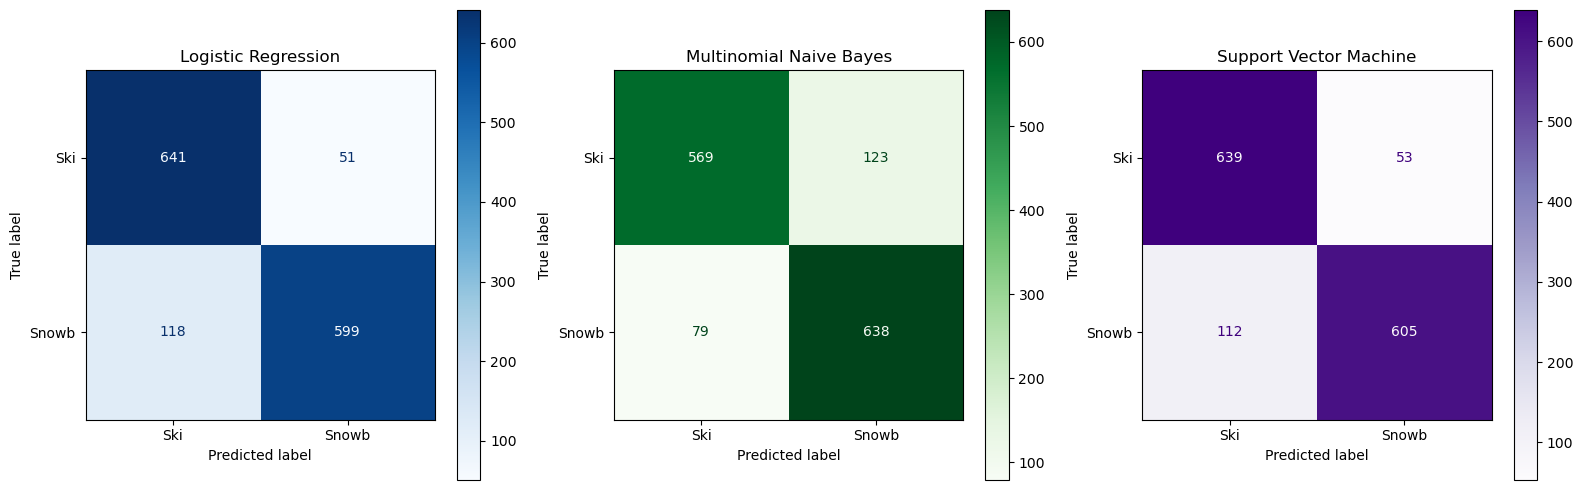

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ConfusionMatrixDisplay.from_predictions(y_test, preds_log, display_labels = ['Ski', 'Snowb'], cmap = 'Blues', ax=ax[0]);
ConfusionMatrixDisplay.from_predictions(y_test, preds_nb, display_labels = ['Ski', 'Snowb'], cmap = 'Greens', ax=ax[1]);
ConfusionMatrixDisplay.from_predictions(y_test, preds_svc, display_labels = ['Ski', 'Snowb'], cmap = 'Purples', ax=ax[2]);


plt.tight_layout()
ax[0].set_title('Logistic Regression')
ax[1].set_title('Multinomial Naive Bayes')
ax[2].set_title('Support Vector Machine');

In [152]:
print(f'\n---------------------- {b1}Logistic{b0} ---------------------- \n {classification_report(y_test, preds_log, digits=4)} \n')
print(f'------------------------- {b1}NB{b0} ------------------------- \n  {classification_report(y_test, preds_nb, digits=4)} \n')
print(f'------------------------- {b1}SVM{b0} ------------------------- \n  {classification_report(y_test, preds_svc, digits=4)}')


---------------------- Logistic ---------------------- 
               precision    recall  f1-score   support

           0     0.8445    0.9263    0.8835       692
           1     0.9215    0.8354    0.8764       717

    accuracy                         0.8801      1409
   macro avg     0.8830    0.8809    0.8800      1409
weighted avg     0.8837    0.8801    0.8799      1409
 

------------------------- NB ------------------------- 
                precision    recall  f1-score   support

           0     0.8781    0.8223    0.8493       692
           1     0.8384    0.8898    0.8633       717

    accuracy                         0.8566      1409
   macro avg     0.8582    0.8560    0.8563      1409
weighted avg     0.8579    0.8566    0.8564      1409
 

------------------------- SVM ------------------------- 
                precision    recall  f1-score   support

           0     0.8509    0.9234    0.8857       692
           1     0.9195    0.8438    0.8800       717

   

##### <span style = 'color: blue'> <u>**Outcomes and Comparison**</u>: </span>

- <span style = 'color: blue'>The logistic regression model best parameters included:</span>
    - <span style = 'color: blue'>TfidfVectorizer</span>
        - <span style = 'color: blue'>max_df=0.85</span>
        - <span style = 'color: blue'>max_features=6000</span>
        - <span style = 'color: blue'>min_df=2</span>
        - <span style = 'color: blue'>stop_words='english' </span>
    - <span style = 'color: blue'>'logr__C': 2.2611</span>
    - <span style = 'color: blue'>'logr__penalty': 'l2'</span>
    <br></br>

- <span style = 'color: blue'>The Multinomial Bayes model best parameters included:</span>
     - <span style = 'color: blue'>TfidfVectorizer</span>
        - <span style = 'color: blue'>max_df=0.8</span>
        - <span style = 'color: blue'>max_features=7000</span>
        - <span style = 'color: blue'>min_df=3</span>
        - <span style = 'color: blue'>stop_words='english'</span>
    - <span style = 'color: blue'>'nb__alpha': 5.0</span>
    <br></br>
        
- <span style = 'color: blue'>The SVM model best parameters included:</span>
    - <span style = 'color: blue'>TfidfVectorizer</span>
        - <span style = 'color: blue'>max_df=0.8</span>
        - <span style = 'color: blue'>max_features=7000</span>
        - <span style = 'color: blue'>min_df=3
        - <span style = 'color: blue'>stop_words': None</span>
    - <span style = 'color: blue'>'svc__C': 1.778 </span>
    - <span style = 'color: blue'>'svc__degree': 2 </span>    <br></br>

- <span style = 'color: blue'>The **Support Vector Machine (SVM)** performed slightly better than Logistic Regression (LR) and Multinomial Naive Bayes (MNB).</span>
    - <span style = 'color: blue'>The SVM had ...
        - A higher testing **accuracy** score than both MNB and SVM (88.3% vs. 88.0% and 85.7%) 
        - A **precision** of 91.2% (compared to LR: 92.2% and MNB: 89.0%)
        - A **sensitivity** of 84.4% (compared to LR: 83.5% and MNB: 83.8%)
        - A **specificity** of 92.3% (compared to LR: 92.6% and MNB: 82.2%)


---
### Ensembling
##### Here we will test if Ensembling Models 1-3 makes a better model, by how much, and any other considerations. 

In [40]:
vc = VotingClassifier([
    ('logr_e', gs_log), 
    ('nb_e', gs_nb),
    ('svc_e', gs_svc)
])

In [41]:
%%time
vc.fit(X_train, y_train)

CPU times: total: 5.78 s
Wall time: 4min 22s


VotingClassifier(estimators=[('logr_e',
                              GridSearchCV(cv=5,
                                           estimator=Pipeline(steps=[('vec',
                                                                      None),
                                                                     ('logr',
                                                                      LogisticRegression(max_iter=1000,
                                                                                         solver='liblinear'))]),
                                           n_jobs=10,
                                           param_grid=[{'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                                                        'logr__penalty': ['l2'],
                                                        'vec': [CountVectorizer(max_d...
                                                       {'svc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                                                        'svc__degree': [2],
                                                        'vec': [TfidfVectorizer(max_df=0.8,
                                                                                max_features=7000,
                                                                                min_df=3)],
                                                        'vec__max_df': [0.8],
                                                        'vec__max_features': [7000,
                                                                              8000],
                                                        'vec__min_df': [3, 5],
                                                        'vec__stop_words': [None]}]))])

In [43]:
print(f'----------------- {b1}Ensembling Scores{b0} -----------------')
print(f'------------------- Train: {round(vc.score(X_train, y_train),4)} -------------------')
print(f'-------------------- Test: {round(vc.score(X_test, y_test),4)} -------------------')

----------------- Ensembling Scores -----------------
------------------- Train: 0.9595 -------------------
-------------------- Test: 0.8815 -------------------


##### <span style = 'color:blue'> Ensembling all three models we built only improved the testing accuracy by 0.3%, therefore we will not proceed with this approach as the gain is insufficient. We instead turn our attention to reducing overfitting.</span>

---
### Reducing Overfitting


#### Model 4: Random Forest and ExtraTrees
##### This model will be attempting to address overfitting. All three models that have been fit have higher training scores than testing scores by ~4-10%:
- Logistic Regression
    - Train = 0.9744
    - Test = 0.8808
- Multinomial Naive Bayes
    - Train = 0.9025
    - Test = 0.8595
- Support Vector Machine
    - Train = 0.9875
    - Test = 0.8772
    
##### We will test Random Forest Classifier and Extra Trees to see if either ameliorates this impact and improves our model.

##### Random Forest

In [44]:
# RANDOM FOREST
pipe_rf = Pipeline([
    ('vec', None),
    ('rf', RandomForestClassifier())
])

In [45]:
pgrid_rf =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None], #tested english as well
    'vec__max_features': [7000], #tested 8000 as well
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'rf__n_estimators': [300, 350],
    'rf__max_depth': [50]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None],
    'vec__max_features': [7000], 
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'rf__n_estimators': [300, 350],
    'rf__max_depth': [50]
    }
]

In [46]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=25)
gs_rf.fit(X_train, y_train)

CPU times: total: 1.19 s
Wall time: 1min 13s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=25,
             param_grid=[{'rf__max_depth': [50], 'rf__n_estimators': [300, 350],
                          'vec': [CountVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=5)],
                          'vec__max_df': [0.8], 'vec__max_features': [7000],
                          'vec__min_df': [3, 5], 'vec__stop_words': [None]},
                         {'rf__max_depth': [50], 'rf__n_estimators': [300, 350],
                          'vec': [TfidfVectorizer()], 'vec__max_df': [0.8],
                          'vec__max_features': [7000], 'vec__min_df': [3, 5],
                          'vec__stop_words': [None]}])

In [47]:
# Make predictions for Accuracy Report
preds_rf = gs_rf.predict(X_test)

In [49]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'-------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9517 --------------------
-------------------- Test: 0.846 ---------------------
Best Params: {'rf__max_depth': 50, 'rf__n_estimators': 300, 'vec': CountVectorizer(max_df=0.8, max_features=7000, min_df=5), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 5, 'vec__stop_words': None}


In [50]:
%%time

rs_rf = RandomizedSearchCV(pipe_rf, pgrid_rf, cv=5, n_iter = 10, n_jobs=25)
rs_rf.fit(X_train, y_train)

CPU times: total: 1.91 s
Wall time: 59.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('rf', RandomForestClassifier())]),
                   n_jobs=25,
                   param_distributions=[{'rf__max_depth': [50],
                                         'rf__n_estimators': [300, 350],
                                         'vec': [CountVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=5)],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': [None]},
                                        {'rf__max_depth': [50],
                                         'rf__n_estimators': [300, 350],
                                         'vec': [TfidfVectorizer()],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': [None]}])

In [51]:
# Make predictions for Accuracy Report
preds_rf_r = rs_rf.predict(X_test)

In [54]:
print(f'--------- {b1}Random Forest w/ RandomizedSearch{b0} ---------')
print(f'-------------------- Train: {round(rs_rf.score(X_train, y_train),4)} -------------------')
print(f'-------------------- Test: {round(rs_rf.score(X_test, y_test),4)} -------------------')
print('Best Params:', rs_rf.best_params_)

--------- Random Forest w/ RandomizedSearch ---------
-------------------- Train: 0.952 -------------------
-------------------- Test: 0.8467 -------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 5, 'vec__max_features': 7000, 'vec__max_df': 0.8, 'vec': CountVectorizer(max_df=0.8, max_features=7000, min_df=5), 'rf__n_estimators': 300, 'rf__max_depth': 50}


In [55]:
rs_rf.best_score_

0.8549797865346147

In [56]:
rs_rf.best_estimator_.named_steps['rf']

RandomForestClassifier(max_depth=50, n_estimators=300)

In [57]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = rs_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_

vec = best_estimator.named_steps['vec']
if isinstance(vec, CountVectorizer):
    feature_names = vec.get_feature_names_out()
elif isinstance(vec, TfidfVectorizer):
    feature_names = vec.transformer_.get_feature_names_out()

print(feature_names)
print(feature_importances)

['000' '04' '10' ... 'youtube' 'zero' 'zone']
[2.24959662e-05 2.02307467e-04 7.27491377e-04 ... 2.35977875e-04
 1.63076117e-05 3.33949868e-05]


In [58]:
# Make df
df = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
df2 = df.reset_index().drop(columns = ['index']).head(30)

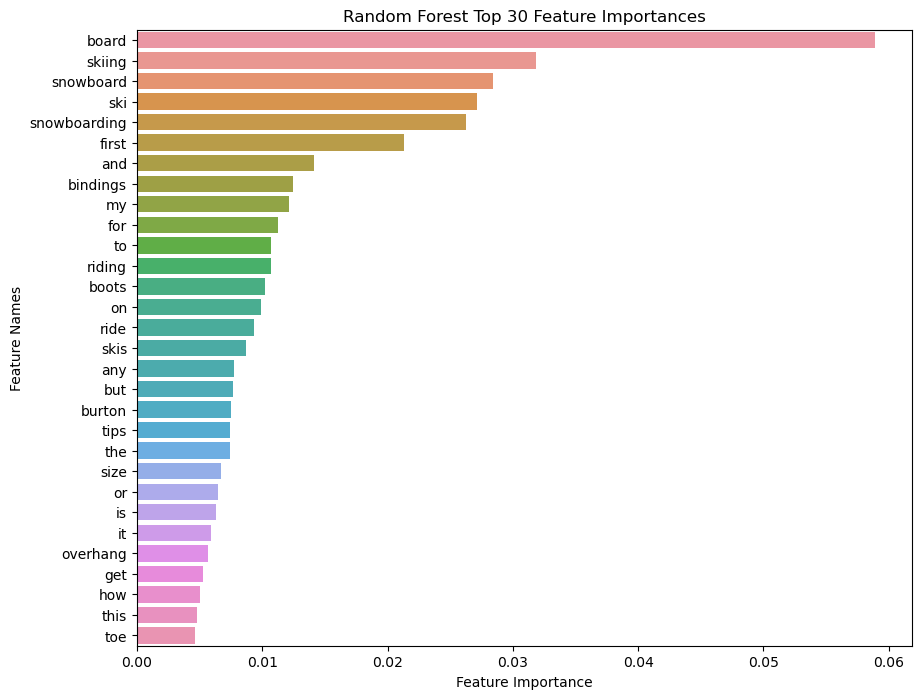

In [60]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=df2['feature_importance'], y=df2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

##### Extra Trees

In [61]:
# EXTRA TREES
pipe_et = Pipeline([
    ('vec', None),
    ('et', ExtraTreesClassifier())
])

In [62]:
pgrid_et =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': ['english'], #tested None as well
    'vec__max_features': [7000], #tested 8000 as well
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'et__n_estimators': [300, 350],
    'et__max_depth': [50]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': ['english'],
    'vec__max_features': [7000], 
    'vec__min_df': [3, 5],
    'vec__max_df': [0.80],
    'et__n_estimators': [300, 350],
    'et__max_depth': [50]
    }
]

In [63]:
%%time

gs_et = GridSearchCV(pipe_et, pgrid_et, cv=5, n_jobs=25)
gs_et.fit(X_train, y_train)

CPU times: total: 1.66 s
Wall time: 47.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('et', ExtraTreesClassifier())]),
             n_jobs=25,
             param_grid=[{'et__max_depth': [50], 'et__n_estimators': [300, 350],
                          'vec': [CountVectorizer()], 'vec__max_df': [0.8],
                          'vec__max_features': [7000], 'vec__min_df': [3, 5],
                          'vec__stop_words': ['english']},
                         {'et__max_depth': [50], 'et__n_estimators': [300, 350],
                          'vec': [TfidfVectorizer(max_df=0.8, max_features=7000,
                                                  min_df=5,
                                                  stop_words='english')],
                          'vec__max_df': [0.8], 'vec__max_features': [7000],
                          'vec__min_df': [3, 5],
                          'vec__stop_words': ['english']}])

In [64]:
# Make predictions for Accuracy Report
preds_et = gs_et.predict(X_test)

In [65]:
print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_et.score(X_train, y_train),4)} -------------------')
print(f'-------------------- Test: {round(gs_et.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_et.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.9196 -------------------
-------------------- Test: 0.8439 --------------------
Best Params: {'et__max_depth': 50, 'et__n_estimators': 300, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=5, stop_words='english'), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 5, 'vec__stop_words': 'english'}


In [66]:
gs_et.best_score_

0.8483578832515002

In [71]:
%%time

rs_et = RandomizedSearchCV(pipe_et, pgrid_et, cv=5, n_iter = 10, n_jobs=25)
rs_et.fit(X_train, y_train)

CPU times: total: 1.19 s
Wall time: 48 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('et', ExtraTreesClassifier())]),
                   n_jobs=25,
                   param_distributions=[{'et__max_depth': [50],
                                         'et__n_estimators': [300, 350],
                                         'vec': [CountVectorizer()],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': ['english']},
                                        {'et__max_depth': [50],
                                         'et__n_estimators': [300, 350],
                                         'vec': [TfidfVectorizer(max_df=0.8,
                                                                 max_features=7000,
                                                                 min_df=5,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.8],
                                         'vec__max_features': [7000],
                                         'vec__min_df': [3, 5],
                                         'vec__stop_words': ['english']}])

In [72]:
# Make predictions for Accuracy Report
preds_et_r = rs_et.predict(X_test)

In [73]:
print(f'---------- {b1}Extra Trees w/ RandomizedSearch{b0} ----------')
print(f'------------------- Train: {round(rs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_et.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_et.best_params_)

---------- Extra Trees w/ RandomizedSearch ----------
------------------- Train: 0.9198 -------------------
------------------- Test: 0.8453 --------------------
Best Params: {'vec__stop_words': 'english', 'vec__min_df': 5, 'vec__max_features': 7000, 'vec__max_df': 0.8, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=5, stop_words='english'), 'et__n_estimators': 300, 'et__max_depth': 50}


In [74]:
rs_et.best_score_

0.8504872214528515

In [75]:
rs_et.best_estimator_.named_steps['et']

ExtraTreesClassifier(max_depth=50, n_estimators=300)

In [76]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = rs_et.best_estimator_
random_forest = best_estimator.named_steps['et']
feature_importances = random_forest.feature_importances_

vec = best_estimator.named_steps['vec']
if isinstance(vec, CountVectorizer):
    feature_names = vec.get_feature_names_out()
elif isinstance(vec, TfidfVectorizer):
    feature_names = vec.transformer_.get_feature_names_out()

print(feature_names)
print(feature_importances)

['000' '04' '10' ... 'youtube' 'zero' 'zone']
[3.27848361e-05 2.13115716e-04 1.15315395e-03 ... 2.20570722e-04
 5.34422441e-05 6.45611415e-05]


In [77]:
# Make df
df = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
df2 = df.reset_index().drop(columns = ['index']).head(30)

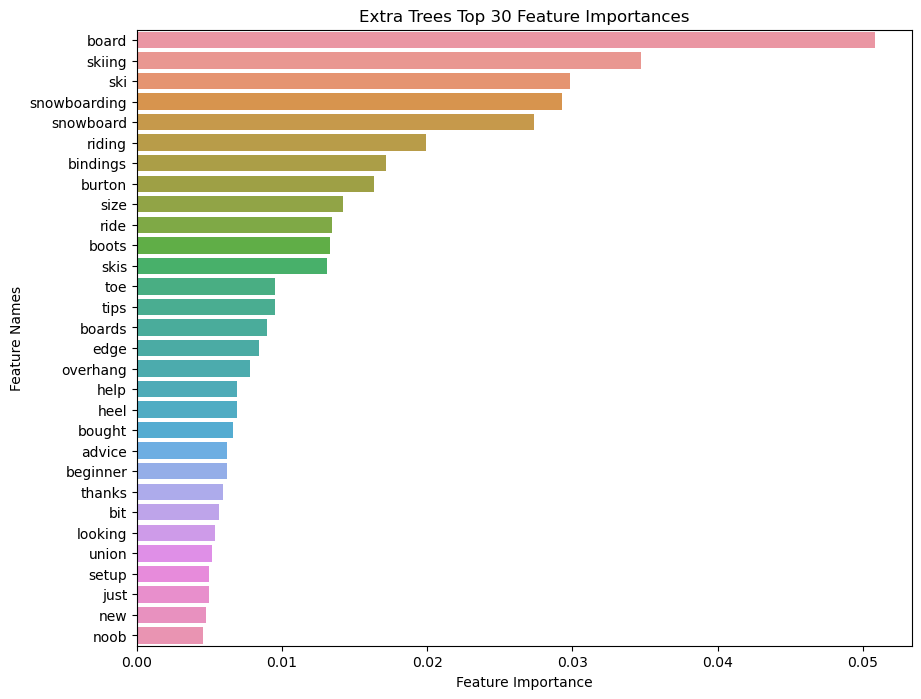

In [78]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=df2['feature_importance'], y=df2['feature_names'])
plt.title('Extra Trees Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

In [80]:
print(f'--------- {b1}Random Forest w/ RandomizedSearch{b0} ---------')
print(f'------------------- Train: {round(rs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(rs_rf.score(X_test, y_test),4)} --------------------\n')

print(f'---------- {b1}Extra Trees w/ RandomizedSearch{b0} ----------')
print(f'------------------- Train: {round(rs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_et.score(X_test, y_test),4)} --------------------')

--------- Random Forest w/ RandomizedSearch ---------
------------------- Train: 0.952 --------------------
------------------- Test: 0.8467 --------------------

---------- Extra Trees w/ RandomizedSearch ----------
------------------- Train: 0.9198 -------------------
------------------- Test: 0.8453 --------------------


### III. Model Summarization

In [81]:
# Taking the best model between the Gridsearches and Randomizedsearches
summ = [gs_log.score(X_test, y_test),
                       gs_nb.score(X_test, y_test),
                       gs_svc.score(X_test, y_test),
                       vc.score(X_test, y_test),
                       rs_rf.score(X_test, y_test),
                       rs_et.score(X_test, y_test)
                      ]
mod = ['Logistic Regression', 'Multinomial Bayes', 'Support Vector Machine', 'Ensemble', 'Random Forest', 'Extra Trees']


In [82]:
overall = pd.DataFrame({'Model': mod, 'Test_Score': summ})
overall

,Model,Test_Score
0,Logistic Regression,0.880057
1,Multinomial Bayes,0.856636
2,Support Vector Machine,0.882896
3,Ensemble,0.881476
4,Random Forest,0.846700
5,Extra Trees,0.845280


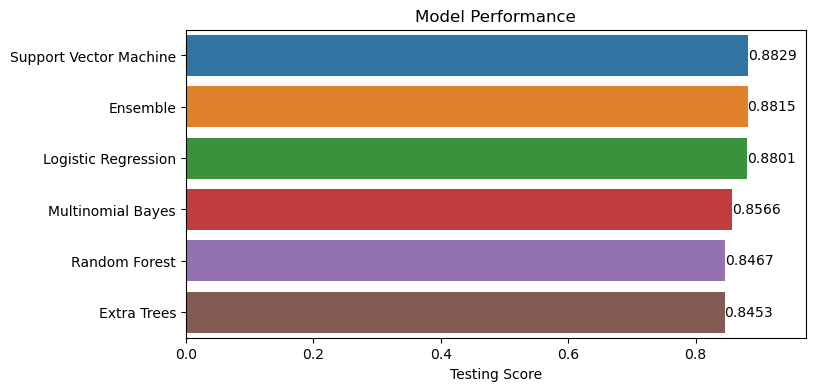

In [112]:
plt.figure(figsize=(8,4))
overall.sort_values(by = 'Test_Score', ascending=False, inplace=True)
sns.barplot(y=overall['Model'], x=overall['Test_Score'], order=overall['Model'])
plt.title('Model Performance')
plt.xlabel('Testing Score')
plt.ylabel(None)


# Add bar values
# source: https://stackoverflow.com/questions/30228069/how-to-display-the-value-on-horizontal-bars, ChatGPT
for i, score in enumerate(overall['Test_Score']):
    plt.text(score, i, f"{score:.4f}", va='center', ha='left')
plt.xlim(0, max(overall['Test_Score']) + .09);



### IV. Final Model

In [19]:
%%time
pipe_logr = Pipeline([
                 ('tvec', TfidfVectorizer(max_df=0.85, max_features=8000, min_df=2)),
                 ('logr', LogisticRegression(C=5.577778, penalty='l2'))
])
pipe_logr.fit(X_train, y_train)

CPU times: total: 281 ms
Wall time: 764 ms


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=8000, min_df=2)),
                ('logr', LogisticRegression(C=5.577778))])

In [23]:
print(f'~~~~~~~~~~~~ {b1}FINAL LOGISTIC MODEL{b0} ~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~ Train: {round(pipe_logr.score(X_train, y_train),4)} ~~~~~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~ Test: {round(pipe_logr.score(X_test, y_test),4)} ~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~ FINAL LOGISTIC MODEL ~~~~~~~~~~~
~~~~~~~~~~~~~~~ Train: 0.9728 ~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~ Test: 0.8836 ~~~~~~~~~~~~~~~~


In [ ]:
pgrid_logr_best =[
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None],
    'vec__max_features': [8000], 
    'vec__min_df': [2],
    'vec__max_df': [0.85],
    'logr__C': 5.577777777777777),
    'logr__penalty': ['l2']
    }
]

In [24]:
%%time
pipe_svc = Pipeline([
                 ('tvec', TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3)),
                 ('svc', SVC(C=1.77779, degree=2))
])
pipe_svc.fit(X_train, y_train)

CPU times: total: 2.86 s
Wall time: 7.7 s


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3)),
                ('svc', SVC(C=1.77779, degree=2))])

In [27]:
print(f'~~~~~~~~~~~~~~ {b1}FINAL SVM MODEL{b0} ~~~~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~ Train: {round(pipe_svc.score(X_train, y_train),4)} ~~~~~~~~~~~~~~~')
print(f'~~~~~~~~~~~~~~~ Test: {round(pipe_svc.score(X_test, y_test),4)} ~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~ FINAL SVM MODEL ~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~ Train: 0.9979 ~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~ Test: 0.8829 ~~~~~~~~~~~~~~~~


In [127]:
pipe_logr = Pipeline([
                 ('tvec', TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2, stop_words='english')),
                 ('logr', LogisticRegression(penalty='l2', C=2.261))
])
pipe_logr.fit(X_train, y_train)

print('Train:', round(pipe_logr.score(X_train, y_train),4))
print('Test:', round(pipe_logr.score(X_test, y_test),4))

Train: 0.9529
Test: 0.8801


In [129]:
%%time
pipe_logr2 = Pipeline([
                 ('tvec', TfidfVectorizer(max_df=0.85, max_features=7000, min_df=2)),
                 ('logr', LogisticRegression(penalty='l2', C=4.472))
])
pipe_logr2.fit(X_train, y_train)

print('Train:', round(pipe_logr2.score(X_train, y_train),4))
print('Test:', round(pipe_logr2.score(X_test, y_test),4))

Train: 0.9674
Test: 0.8829
CPU times: total: 594 ms
Wall time: 919 ms


In [ ]:
SVM: Best Params: {'svc__C': 1.5, 'svc__degree': 2, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': None} -->0.8829
Best Params: {'svc__C': 1.7777888888888889, 'svc__degree': 2, 'vec': TfidfVectorizer(max_df=0.8, max_features=7000, min_df=3), 'vec__max_df': 0.8, 'vec__max_features': 7000, 'vec__min_df': 3, 'vec__stop_words': None}--0.877

In [ ]:
LOGISTIC RANDOMIZED: Best Params: {'vec__stop_words': None, 'vec__min_df': 2, 'vec__max_features': 7000, 'vec__max_df': 0.95, 'vec': TfidfVectorizer(max_df=0.95, max_features=8000, min_df=2), 'logr__penalty': 'l2', 'logr__C': 4.472222222222221}

In [135]:
# Define hyperparameters
pgrid_logr =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.85], #tested 0.8, 0.95 as well
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,10.0,10),
    'logr__penalty': ['l2'] #tested l1, l2 was more optimal
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 8000], 
    'vec__min_df': [2, 3],
    'vec__max_df': [0.85],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,10.0,10),
    'logr__penalty': ['l2']
    }
]

In [148]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_log = RandomizedSearchCV(pipe_log, pgrid_logr, cv=5, n_iter=10, n_jobs=10)
rs_log.fit(X_train, y_train)

CPU times: total: 797 ms
Wall time: 9.93 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('logr',
                                              LogisticRegression(max_iter=1000,
                                                                 solver='liblinear'))]),
                   n_jobs=10,
                   param_distributions=[{'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                                         'logr__penalty': ['l2'],
                                         'vec': [CountVectorizer(max_df=0.85,
                                                                 max_features=7000...
                                         'vec__stop_words': [None, 'english']},
                                        {'logr__C': array([ 0.05      ,  1.15555556,  2.26111111,  3.36666667,  4.47222222,
        5.57777778,  6.68333333,  7.78888889,  8.89444444, 10.        ]),
                                         'logr__penalty': ['l2'],
                                         'vec': [TfidfVectorizer(max_df=0.85,
                                                                 max_features=7000,
                                                                 min_df=2,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.85],
                                         'vec__max_features': [7000, 8000],
                                         'vec__min_df': [2, 3],
                                         'vec__stop_words': [None, 'english']}])

In [149]:
print(f'--------- {b1}Logistic Regression w/ GridSearch{b0} ---------') # source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
print(f'------------------- Train: {round(rs_log.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(rs_log.score(X_test, y_test),4)} --------------------')
print('Best Params:', rs_log.best_params_)

--------- Logistic Regression w/ GridSearch ---------
------------------- Train: 0.9678 -------------------
------------------- Test: 0.8701 --------------------
Best Params: {'vec__stop_words': None, 'vec__min_df': 2, 'vec__max_features': 7000, 'vec__max_df': 0.85, 'vec': CountVectorizer(max_df=0.85, max_features=7000, min_df=2), 'logr__penalty': 'l2', 'logr__C': 1.1555555555555554}
